<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch8-Integrated_Planning_Learning/Dyna_Qplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
%matplotlib inline

# Comparison between DYNA-Q and DYNA-Q+

## Dyna Maze

In [2]:
VALID = 0
START = 1
PATH = 2
FINISH = 3
OBSTACLE = 4

def get_maze():
  nRows = 6
  nCols = 9
  map_1 = np.zeros((nRows,nCols),dtype=np.int8)
  map_1[5,3] = START
  map_1[0,8] = FINISH
  map_1[3,:8] = OBSTACLE

  map_2 = np.zeros((nRows,nCols),dtype=np.int8)
  map_2[5,3] = START
  map_2[0,8] = FINISH
  map_2[3,1:] = OBSTACLE
  return map_1,map_2

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  cmap = colors.ListedColormap(['white','red','blue','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,2,num)
  ax.imshow(map, cmap=cmap,alpha=0.6)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Map

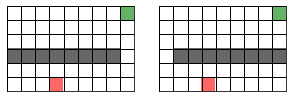

In [3]:
map_1,map_2 = get_maze()
fig = plt.figure(figsize=(5,3))
plot_circuit(fig,map_1,1)
plot_circuit(fig,map_2,2)

### Constant Parameters

In [4]:
num_trials = 1
num_steps = 3000
step_change = 1000

alpha = 0.1
gamma = 0.95
epsilon = 0.3
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]
start = [5,3]
goal  = [0,8]
map = np.copy(map_1)

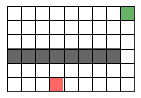

In [5]:
fig = plt.figure(figsize=(5,3))
plot_circuit(fig,map,1)

In [6]:
def step(state,action):
  new_state = [max(0,min(map.shape[0]-1,state[0]+action[0])),max(0,min(map.shape[1]-1,state[1]+action[1]))]
  reward = 0
  if map[new_state[0],new_state[1]] == OBSTACLE:
    return state,reward
  if new_state == goal:
    reward = 1
  return new_state,reward

def target_policy(Q,pos,actions,epsilon):
  nA = len(actions)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q[pos[0],pos[1],:])
  idx = np.where(Q[pos[0],pos[1],:] == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  return np.random.choice(range(nA),p=action_prob)

def get_action_idx(action):
  return np.where(np.sum(np.abs(actions-action),1) == 0)[0][0]

def TabularDynaQ(num_steps,actions,alpha,gamma,epsilon,plan_steps):
  nA = len(actions)
  global map
  Q = np.zeros((map.shape[0],map.shape[1],nA))
  stats = [[0,0]]
  model = dict()
  traj = set()
  steps = 0
  cum_reward = 0
  pos = start
  for steps in tqdm(range(num_steps)):
    if steps == 1000:
      map = np.copy(map_2)
    if pos == goal:
      pos = start
    act_idx = target_policy(Q,pos,actions,epsilon)
    next_pos,reward = step(pos,actions[act_idx])

    ## Update Q
    Q[pos[0],pos[1],act_idx] += alpha*(reward + gamma*max(Q[next_pos[0],next_pos[1],:]) - Q[pos[0],pos[1],act_idx])
    ## Update Model
    t = (pos[0],pos[1],act_idx)
    traj.add(t)
    model[(pos[0],pos[1],act_idx)] = (next_pos[0],next_pos[1],reward)
    ## Planning
    plan_c = 0
    while plan_c < plan_steps:
      t = list(traj)[np.random.choice(range(len(traj)))]
      s = [t[0],t[1]]
      a_idx = t[2]
      s_next,r = step(s,actions[a_idx])
      Q[s[0],s[1],a_idx] += alpha*(r + gamma*max(Q[s_next[0],s_next[1],:]) - Q[s[0],s[1],a_idx])
      plan_c += 1
    pos = next_pos.copy()
    cum_reward += reward
    stats += [[steps,cum_reward]]
  return np.array(stats)

In [7]:
plan_steps = 50
stats = TabularDynaQ(num_steps,hv_actions,alpha,gamma,epsilon,plan_steps)

100%|██████████| 3000/3000 [00:04<00:00, 645.96it/s]


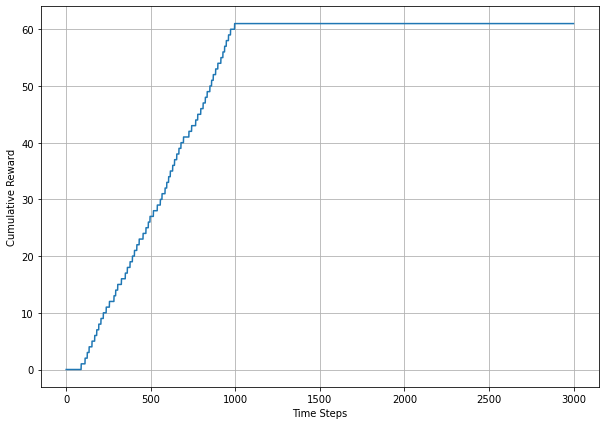

In [8]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(stats[:,0],stats[:,1])
ax.grid(True)
# ax.legend(['Planning steps = '+ str(p) for p in plan_steps])
ax.set_xlabel('Time Steps')
ax.set_ylabel('Cumulative Reward');
# print('Optimal Steps to Goal = ', stats_avg[-1,1:])

In [9]:
plot_circuit(fig,map,1)